# X-PSI twospot example

In [1]:
%matplotlib inline

from __future__ import print_function, division

import numpy as np
import math

import matplotlib

from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams, rc
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib import gridspec, ticker

import sys
import xpsi
                   
import os

from xpsi import PostProcessing
PostProcessing.publication_rc_settings()
PostProcessing.random_seed = 0

from xpsi.global_imports import _dpr, _keV, _k_B

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|              Version: 0.1                 |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [2]:
PostProcessing.publication_rc_settings()

In [48]:
from CustomData import CustomData                                                                                                               
from CustomInstrument import CustomInstrument                                                                                                   
from CustomPulse import CustomPulse                                                                                                             
from CustomSpacetime import CustomSpacetime                                                                                                     
from CustomPrior import CustomPrior                                                                                                             
from CustomBackground import CustomBackground                                                                                                   
                                                                                                                                                
data = CustomData.from_SWG('../data/synthetic_realisation.dat', 984307.6661)                                                                     
                                                                                                                                                
NICER = CustomInstrument.from_SWG(num_params=0,                                                                                                 
                                  bounds=[],
                                  ARF = '../model_data/nicer_v1.01_arf.txt',                                                                       
                                  RMF = '../model_data/nicer_v1.01_rmf_matrix.txt',
                                  max_input=500,                                                                                   
                                  min_input=0,
                                  chan_edges = '../model_data/nicer_v1.01_rmf_energymap.txt')                                                                                                                                              
pulse = CustomPulse(tag = 'all',                                                                                                                
                    num_params = 2,                                                                                                             
                    bounds = [(-0.25, 0.75), (-0.25, 0.75)],                                                                                    
                    data = data,                                                                                                                
                    instrument = NICER,                                                                                                         
                    background = None,                                                                                                          
                    interstellar = None,                                                                                                        
                    energies_per_interval = 0.5,                                                                                                
                    default_energy_spacing = 'logspace',                                                                                        
                    fast_rel_energies_per_interval = 0.5,                                                                                       
                    workspace_intervals = 1000,                                                                                                 
                    adaptive_energies = False,                                                                                                  
                    store = True,                                                                                                              
                    epsrel = 1.0e-8,                                                                                                            
                    epsilon = 1.0e-3,                                                                                                           
                    sigmas = 10.0)                                                                                                              
                                                                                                                                                
from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius                                                                                  
                                                                                                                                                
bounds = [(0.1, 1.0),                                                                                                                           
          (1.0, 3.0),                                                                                                                           
          (3.0 * gravradius(1.0), 16.0),                                                                                                        
          (0.001, math.pi/2.0)]                                                                                                                 
                                                                                                                                                
spacetime = CustomSpacetime(num_params = 4, bounds = bounds, S = 300.0)                                                                         
                                                                                                                                                
bounds = [(0.001, math.pi - 0.001),                                                                                                             
          (0.001, math.pi/2.0 - 0.001),                                                                                                         
          (5.5, 6.5),                                                                                                                           
          (0.001, math.pi - 0.001),                                                                                                             
          (0.001, math.pi/2.0 - 0.001),                                                                                                         
          (5.5, 6.5)]                                                                                                                           
                                                                                                                                                
spot = xpsi.Spots(num_params=(3,3), bounds=bounds,                                                                                              
                    symmetry=True,                                                                                                              
                    hole=False,                                                                                                                 
                    cede=False,                                                                                                                 
                    concentric=False,                                                                                                           
                    antipodal_symmetry=False,                                                                                                   
                    sqrt_num_cells=32,                                                                                                          
                    min_sqrt_num_cells=10,                                                                                                      
                    max_sqrt_num_cells=64,                                                                                                      
                    do_fast=False,                                                                                                              
                    num_leaves=100,                                                                                                             
                    num_rays=200)                                                                                                               
                                                                                                                                                
photosphere = xpsi.Photosphere(num_params = 0, bounds = [],                                                                                     
                               tag = 'all', spot = spot, elsewhere = None)                                                                      
                                                                                                                                                
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)                                                                             
                                                                                                                                                
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1)                                                                            
                                                                                                                                                
prior = CustomPrior(bounds=likelihood.bounds, spacetime=spacetime)                                                                              
                                                                                                                                                
likelihood.prior = prior

In [50]:
np.sum(pulse._precomp) # should be: -24413582.28500478

-24413582.28500478

In [7]:
prior.estimate_hypercube_frac(4)

>> Estimating fractional hypervolume of the unit hypercube with finite prior density:
Requiring 1E+04 draws from the prior support for Monte Carlo estimation.
The support of the joint prior occupies an estimated fraction 0.1548 of the hypervolume within the unit hypercube.
>> Fractional hypervolume estimated.


0.1547508511296812

In [13]:
def get_prior_samps(prior, ndraws):
    ndraws = int(10**ndraws)                                                                                 
    h = np.random.rand(ndraws, len(prior._bounds))
    thetas = np.zeros((ndraws, len(prior._bounds) + 5))

    finite_counter = counter = index = 0                                                                                            
    while finite_counter < ndraws:                                                                                                  
        try:                                                                                                                        
            p = prior.inverse_sample_and_transform(h[index, :])                                                                                    
        except IndexError: # use estimate to draw more from hypercube                                                               
            redraw = float(counter) * ndraws / finite_counter
            redraw -= finite_counter                                                                                                
            h = np.random.rand(int(redraw)+1, len(prior._bounds))                                                                   
            index = 0                                                                                                               
            p = prior.inverse_sample_and_transform(h[index, :])                                                                                    

        if np.isfinite(prior(p)):                                                                                          
            thetas[finite_counter,:] = p
            finite_counter += 1 
        counter += 1                                                                                                                
        index += 1
    
    return thetas

In [14]:
prior._bounds

[(0.1, 1.0),
 (1.0, 3.0),
 (4.429875115500001, 16.0),
 (0.001, 1.5707963267948966),
 (0.001, 3.1405926535897932),
 (0.001, 1.5697963267948967),
 (5.5, 6.5),
 (0.001, 3.1405926535897932),
 (0.001, 1.5697963267948967),
 (5.5, 6.5),
 (-0.25, 0.75),
 (-0.25, 0.75)]

In [15]:
prior.inverse_sample_and_transform(np.random.rand(12))

[0.20872916113503864,
 2.0764478521341934,
 11.152955205559199,
 0.1910563909847365,
 1.2568837938289348,
 0.35054311229454976,
 6.143263333918364,
 3.126195479032605,
 1.1002991046708197,
 5.601834800340207,
 0.3610622550813124,
 0.08096392742348446,
 0.27491681200984097,
 0.21990167234217206,
 -1.0658274028441983,
 1.4479401848136713,
 -2.9351390880478685]

In [16]:
prior_samps = get_prior_samps(prior, 5.0)

/home/thomas/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


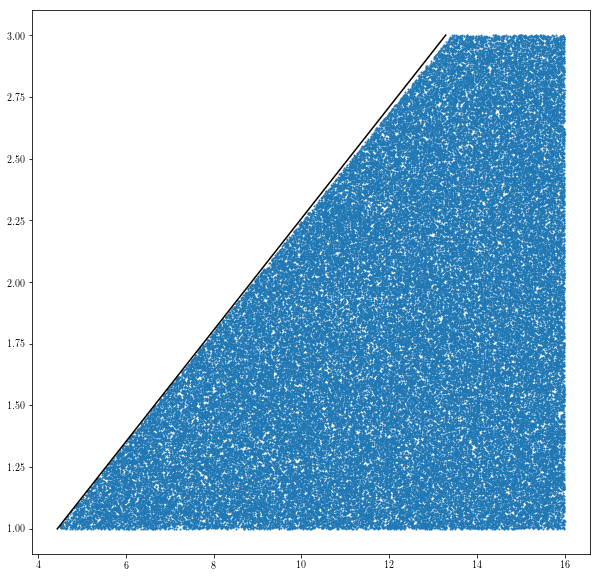

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(prior_samps[:,2], prior_samps[:,1], s=1.0)
plt.plot(3.0*gravradius(np.linspace(1.0,3.0,100)), np.linspace(1.0,3.0,100), 'k')

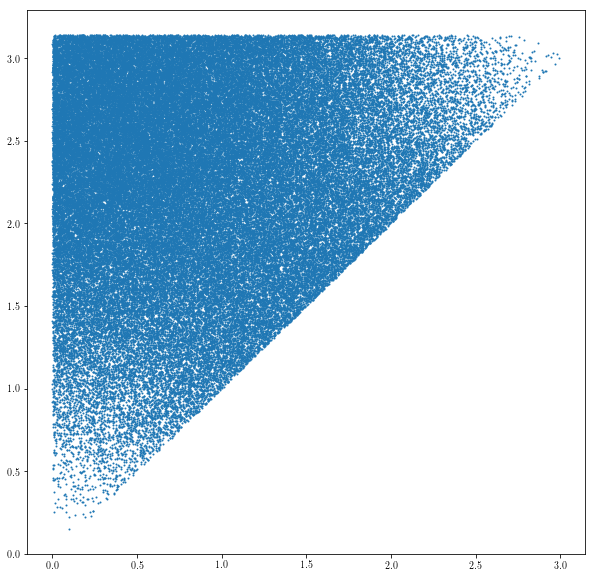

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(prior_samps[:,4], prior_samps[:,7], s=1.0)

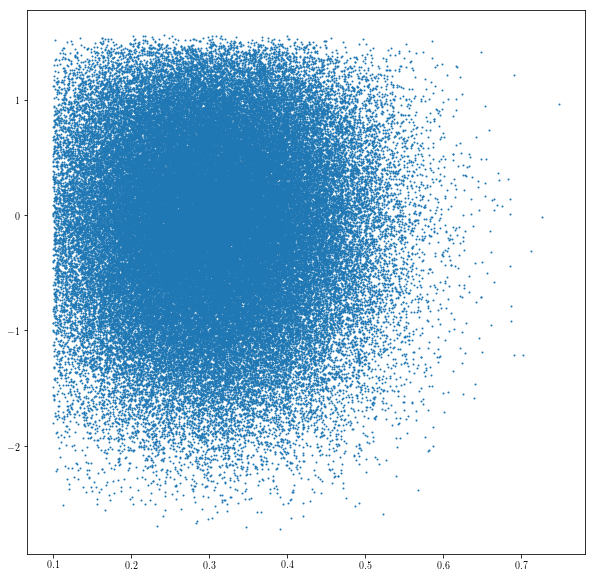

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(prior_samps[:,0], prior_samps[:,-3], s=1.0)

In [20]:
print(CustomPrior.__doc__)

 A custom (joint) prior distribution.

    Currently tailored to the NICER light-curve SWG model specification.

    Source: Imaginary
    Model variant: ST-U

    Parameter vector:

    * p[0] = distance (kpc)
    * p[1] = (rotationally deformed) gravitational mass (solar masses)
    * p[2] = coordinate equatorial radius (km)
    * p[3] = inclination of Earth to rotational axis (radians)
    * p[4] = primary cap centre colatitude (radians)
    * p[5] = primary cap angular radius (radians)
    * p[6] = primary cap log10(comoving blackbody temperature [K])
    * p[7] = secondary cap centre colatitude (radians)
    * p[8] = secondary cap angular radius (radians)
    * p[9] = secondary cap log10(comoving blackbody temperature [K])
    * p[10] = primary cap phase shift (cycles); (alias for initial azimuth, periodic)
    * p[11] = secondary cap phase shift (cycles)

    


In [51]:
inj = [0.2, 1.4, 12.5, 1.25,
         1.0, 0.075, 6.2,
         math.pi - 1.0, 0.2, 6.0,
         0.0, 0.025]

In [52]:
MML = [0.183906328957459286E+00,
       0.142823300681121834E+01,
       0.147642717938172616E+02,
       0.137714517976092110E+01,
       0.766746352696564104E+00,
       0.643253383599858564E-01,
       0.618464074329834368E+01,
       0.238341656540778013E+01,
       0.168377819548832186E+00,
       0.598853512117529974E+01,
       0.222137502864100389E-02,
       0.276063508599878604E-01]

In [55]:
%%prun
likelihood.threads=1

likelihood._theta = [0]*len(likelihood._theta)
ll = likelihood(MML)

In [56]:
ll

-26703.41617929172

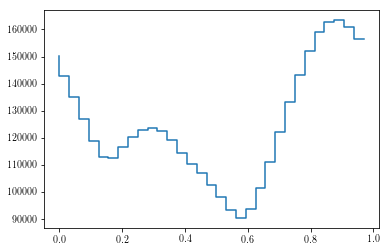

In [33]:
plt.step(pulse.data.phases[:-1], np.sum(pulse.expected_counts,axis=0))

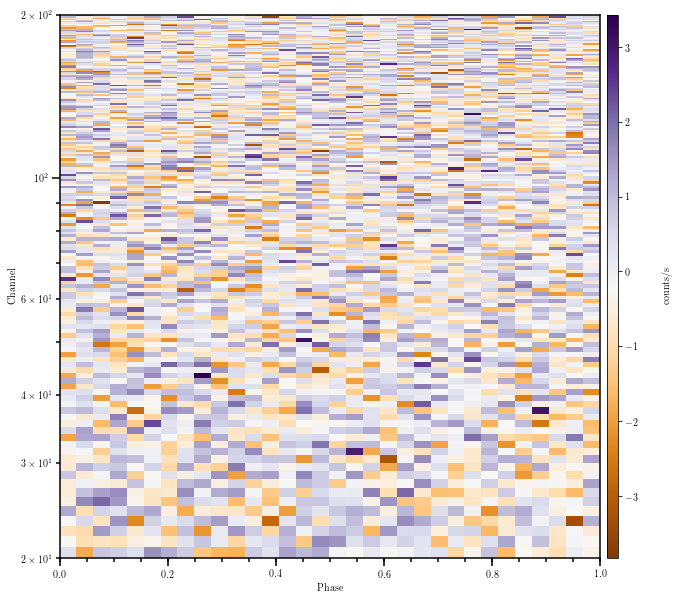

In [26]:
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from matplotlib import cm

fig = plt.figure(figsize = (10,10))

gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
ax = plt.subplot(gs[0])
ax_cb = plt.subplot(gs[1])

profile = ax.pcolormesh(data.phases,
                         NICER.channels,
                         (pulse.expected_counts - data.counts)/np.sqrt(pulse.expected_counts),
                         cmap = plt.cm.PuOr,
                         linewidth = 0,
                         rasterized = True)

profile.set_edgecolor('face')

ax.tick_params(which='major', colors='black', length=8)
ax.tick_params(which='minor', colors='black', length=4)
ax.xaxis.set_tick_params(which='both', width=1.5)
ax.yaxis.set_tick_params(which='both', width=1.5)
plt.setp(ax.spines.values(), linewidth=1.5, color='black')

ax.set_xlim([0.0, 1.0])
ax.set_yscale('log')
ax.set_ylabel(r'Channel')
[i.set_color("black") for i in ax.get_xticklabels()]
[i.set_color("black") for i in ax.get_yticklabels()]
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xlabel(r'Phase')

cb = plt.colorbar(profile,
                  cax = ax_cb)

cb.set_label(label=r'counts/s', labelpad=25)
cb.solids.set_edgecolor('face')

plt.subplots_adjust(wspace = 0.025)

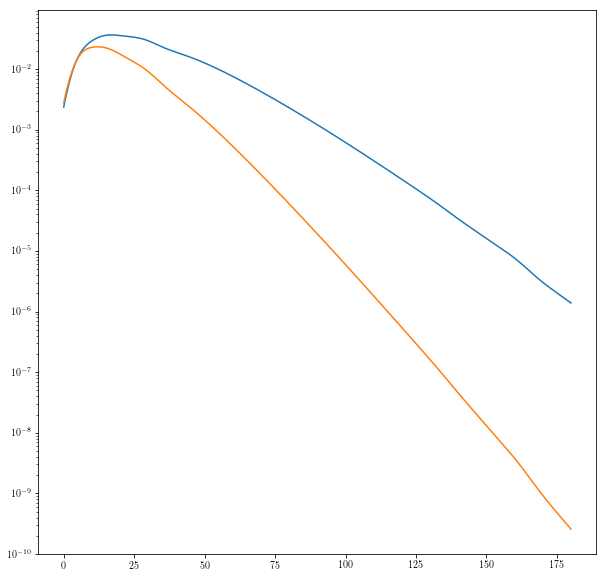

In [27]:
fig = plt.figure(figsize=(10,10))

for spectrum in pulse.pulse:
    plt.plot(np.sum(spectrum/100.0, axis=1), ls='-')
    
plt.gca().set_yscale('log')

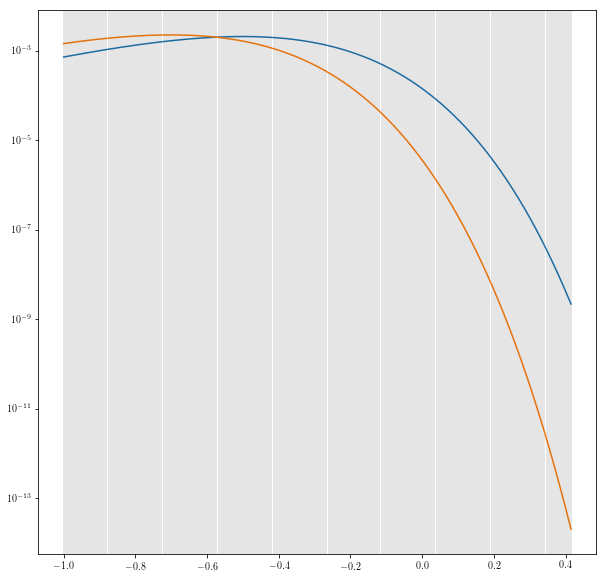

In [28]:
fig = plt.figure(figsize=(10,10))

for spectrum in pulse.raw_signals:
    plt.plot(np.log10(pulse.logspace_energies_hires), pulse.logspace_energies_hires*np.sum(spectrum, axis=1)/100.0, ls='-')

for E in pulse.default_energies:
    plt.axvline(np.log10(E), lw=0.2, color='k')

plt.gca().set_yscale('log')

In [29]:
signal = xpsi.tools.phase_integrator.phase_integrator(1.0,                                                                                                          
                                                      np.array([0.0,1.0]),                                                                                         
                                                      pulse.pulse[0],                                                                                                       
                                                      pulse.phases,                                                                                             
                                                      0.0)

signal += xpsi.tools.phase_integrator.phase_integrator(1.0,                                                                                                          
                                                       np.array([0.0,1.0]),                                                                                         
                                                       pulse.pulse[1],                                                                                                       
                                                       pulse.phases,                                                                                             
                                                       0.0)

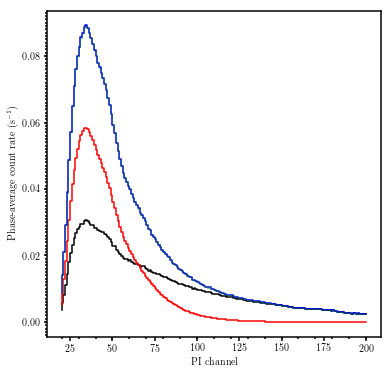

In [30]:
figure = plt.figure(figsize=(6,6))

plt.step(pulse.instrument.channels, pulse.background_signal/pulse.data.exposure_time, 'k-')
plt.step(pulse.instrument.channels, signal.reshape(-1), 'r-')
plt.step(pulse.instrument.channels, np.sum(pulse.data.counts,axis=1)/pulse.data.exposure_time, 'b-')
plt.step(pulse.instrument.channels, pulse.background_signal/pulse.data.exposure_time + signal.reshape(-1), 'g-', lw=0.5)

ax = plt.gca()

ax.set_ylabel('Phase-average count rate (s$^{-1}$)')
ax.set_xlabel('PI channel')
ax.xaxis.set_minor_locator(MultipleLocator(10.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))

ax.xaxis.set_tick_params(which='both', width=1.5)                                                                                
ax.yaxis.set_tick_params(which='both', width=1.5)
for spine in ax.spines.itervalues():                                                                                            
    spine.set_linewidth(1.5)

## posterior

In [40]:
print(CustomPrior.__doc__)

 A custom (joint) prior distribution.

    Currently tailored to the NICER light-curve SWG model specification.

    Source: Imaginary
    Model variant: ST-U

    Parameter vector:

    * p[0] = distance (kpc)
    * p[1] = (rotationally deformed) gravitational mass (solar masses)
    * p[2] = coordinate equatorial radius (km)
    * p[3] = inclination of Earth to rotational axis (radians)
    * p[4] = primary cap centre colatitude (radians)
    * p[5] = primary cap angular radius (radians)
    * p[6] = primary cap log10(comoving blackbody temperature [K])
    * p[7] = secondary cap centre colatitude (radians)
    * p[8] = secondary cap angular radius (radians)
    * p[9] = secondary cap log10(comoving blackbody temperature [K])
    * p[10] = primary cap phase shift (cycles); (alias for initial azimuth, periodic)
    * p[11] = secondary cap phase shift (cycles)

    


In [35]:
names = ['distance', 'mass', 'radius', 'inclination',
         'colatitude_p',
         'radius_p',
         'temperature_p',
         'colatitude_s',
         'radius_s',
         'temperature_s',
         'phase_shift_p',
         'phase_shift_s',
         'compactness',
         'phase_separation',
         'imp',
         'ipp',
         'ims']

# the hard bounds imposed above
bounds = {'distance': (0.1, 1.0),
          'mass': (1.0, 3.0),
          'radius': (3.0 * gravradius(1.0), 16.0),
          'inclination': (0.001, math.pi/2.0),
          'colatitude_p': (0.001, math.pi - 0.001),
          'radius_p': (0.001, math.pi/2.0 - 0.001),
          'temperature_p': (5.5, 6.5),
          'colatitude_s': (0.001, math.pi - 0.001),
          'radius_s': (0.0, math.pi/2.0 - 0.001),
          'temperature_s': (5.1, 6.8),
          'phase_shift_p': (-0.5,0.5),
          'phase_shift_s': (-0.5,0.5),
          'compactness': (gravradius(1.0)/16.0, 1.0/3.0),
          'phase_separation': (0.0,1.0),
          'imp': (0.002 - math.pi, math.pi/2.0 - 0.001),
          'ipp': (0.002, 3.0*math.pi/2.0 - 0.001),
          'ims': (0.002 - math.pi, math.pi/2.0 - 0.001)}

# LaTeX compatible labels
labels = {'distance': r"D\;\mathrm{[kpc]}",
          'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
          'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
          'inclination': r"i\;\mathrm{[rad]}",
          'colatitude_p': r"\Theta_{p}\;\mathrm{[rad]}",
          'radius_p': r"\zeta_{p}\;\mathrm{[rad]}",
          'temperature_p': r"\mathrm{log10}(\mathcal{T}_{\mathrm{p}}\;[\mathrm{K}])",
          'colatitude_s': r"\Theta_{s}\;\mathrm{[rad]}",
          'radius_s': r"\zeta_{s}\;\mathrm{[rad]}",
          'temperature_s': r"\mathrm{log10}(\mathcal{T}_{\mathrm{s}}\;[\mathrm{K}])",
          'phase_shift_p': r"\phi_{p}\;\mathrm{[cycles]}",
          'phase_shift_s': r"\phi_{s}\;\mathrm{[cycles]}",
          'compactness': r"M/R_{\mathrm{eq}}",
          'phase_separation': r"\Delta\phi\;\mathrm{[cycles]}",
          'imp': r"i-\Theta_{p}\;\mathrm{[radians]}",
          'ipp': r"i+\Theta_{p}\;\mathrm{[radians]}",
          'ims': r"i-\Theta_{s}\;\mathrm{[radians]}"}

getdist_kde_settings = {'ignore_rows': 0,
                         'min_weight_ratio': 1.0e-10,
                         'contours': [0.683, 0.954, 0.997],
                         'credible_interval_threshold': 0.001,
                         'range_ND_contour': 0,
                         'range_confidence': 0.001,
                         'fine_bins': 1024,
                         'smooth_scale_1D': -1,
                         'num_bins': 100,
                         'boundary_correction_order': 1,
                         'mult_bias_correction_order': 1,
                         'smooth_scale_2D': -1,
                         'max_corr_2D': 0.99,
                         'fine_bins_2D': 512,
                         'num_bins_2D': 40}

In [36]:
truths = [0.2, 1.4, 12.5, 1.25,
             1.0, 0.075, 6.2,
             math.pi - 1.0, 0.2, 6.0,
             0.0, 0.025, gravradius(1.4)/12.5, 0.525, 0.25, 2.25, 2.25 - math.pi]

In [37]:
truths = dict(zip(names, truths))

In [38]:
truths

{'colatitude_p': 1.0,
 'colatitude_s': 2.141592653589793,
 'compactness': 0.165382004312,
 'distance': 0.2,
 'imp': 0.25,
 'ims': -0.8915926535897931,
 'inclination': 1.25,
 'ipp': 2.25,
 'mass': 1.4,
 'phase_separation': 0.525,
 'phase_shift_p': 0.0,
 'phase_shift_s': 0.025,
 'radius': 12.5,
 'radius_p': 0.075,
 'radius_s': 0.2,
 'temperature_p': 6.2,
 'temperature_s': 6.0}

In [39]:
pp = PostProcessing.PostProcessor.load_runs(['./runs/run3/run3_nlive2000_eff0.3_noCONST_noMM_noIS_tol-1',
                                             './runs/run2/run2_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1',
                                             './runs/run1/run1_nlive1000_eff0.3_noCONST_noMM_noIS_tol-1',
                                             './runs/run_MM/run2_nlive1000_eff0.3_noCONST_MM_noIS_tol-1'],
                                            ['run 3','run 2','run 1', 'run MM'],
                                            use_nestcheck=[True,True,True,False],
                                            base_dir='./',
                                            kde_settings=getdist_kde_settings,
                                            names=names,
                                            bounds=bounds,
                                            labels=labels,
                                            truths=truths,
                                            implementation='multinest',
                                            transform=prior.transform,
                                            likelihood=likelihood)

In [10]:
pp.KL_divergence(bootstrap=True, n_simulate=500)

[array([72.08975007]), array([72.54901917]), array([72.98127842])]

In [11]:
KL = np.array([72.08975007,72.54901917,72.98127842])

In [12]:
KL[1] - KL[0]

0.4592691000000002

In [13]:
KL[2] - KL[1]

0.4322592500000013

In [19]:
cred_ints = [0.05, 0.5, 0.95]

In [20]:
import nestcheck

In [26]:
for c in cred_ints:
    _ = nestcheck.error_analysis.run_ci_bootstrap(pp.runs.combined.nestcheck_backend,
                                                  estimator_list=[nestcheck.estimators.logz],
                                                  cred_int=c,
                                                  n_simulate=500,
                                                  simulate_weights=True,
                                                  flip_skew=True)
    print(_)

[-26759.58376876]
[-26759.32685749]
[-26759.06018695]


In [27]:
Z = np.array([-26759.58376876, -26759.32685749, -26759.06018695])

In [29]:
Z[1] - Z[0]

0.25691127000027336

In [30]:
Z[2] - Z[1]

0.2666705400006322

In [87]:
pp.runs['run 1'].names

['distance',
 'mass',
 'radius',
 'inclination',
 'colatitude_p',
 'radius_p',
 'temperature_p',
 'colatitude_s',
 'radius_s',
 'temperature_s',
 'phase_shift_p',
 'phase_shift_s',
 'compactness']

>> Executing posterior density estimation...
>> Curating set of runs for posterior plotting...
>> Run set curated.
>> Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['distance', 'radius']
plotting:  ['distance', 'mass']
plotting:  ['distance', 'inclination']
plotting:  ['distance', 'colatitude_p']
plotting:  ['distance', 'radius_p']
plotting:  ['distance', 'temperature_p']
plotting:  ['distance', 'colatitude_s']
plotting:  ['distance', 'radius_s']
plotting:  ['distance', 'temperature_s']
plotting:  ['distance', 'phase_shift_p']
plotting:  ['distance', 'phase_separation']
plotting:  ['radius', 'mass']
plotting:  ['radius', 'inclination']
plotting:  ['radius', 'colatitude_p']
plotting:  ['radius', 'radius_p']
plotting:  ['radius', 'temperature_p']
plotting:  ['radius', 'colatitude_s']
plotting:  ['radius', 'radius_s']
plotting:  ['radius', 'temperature_s']
plotting:  ['radius', 'phase_shift_p']
plotting:  ['radius', 'phase_separation']
plotting:  ['mass',

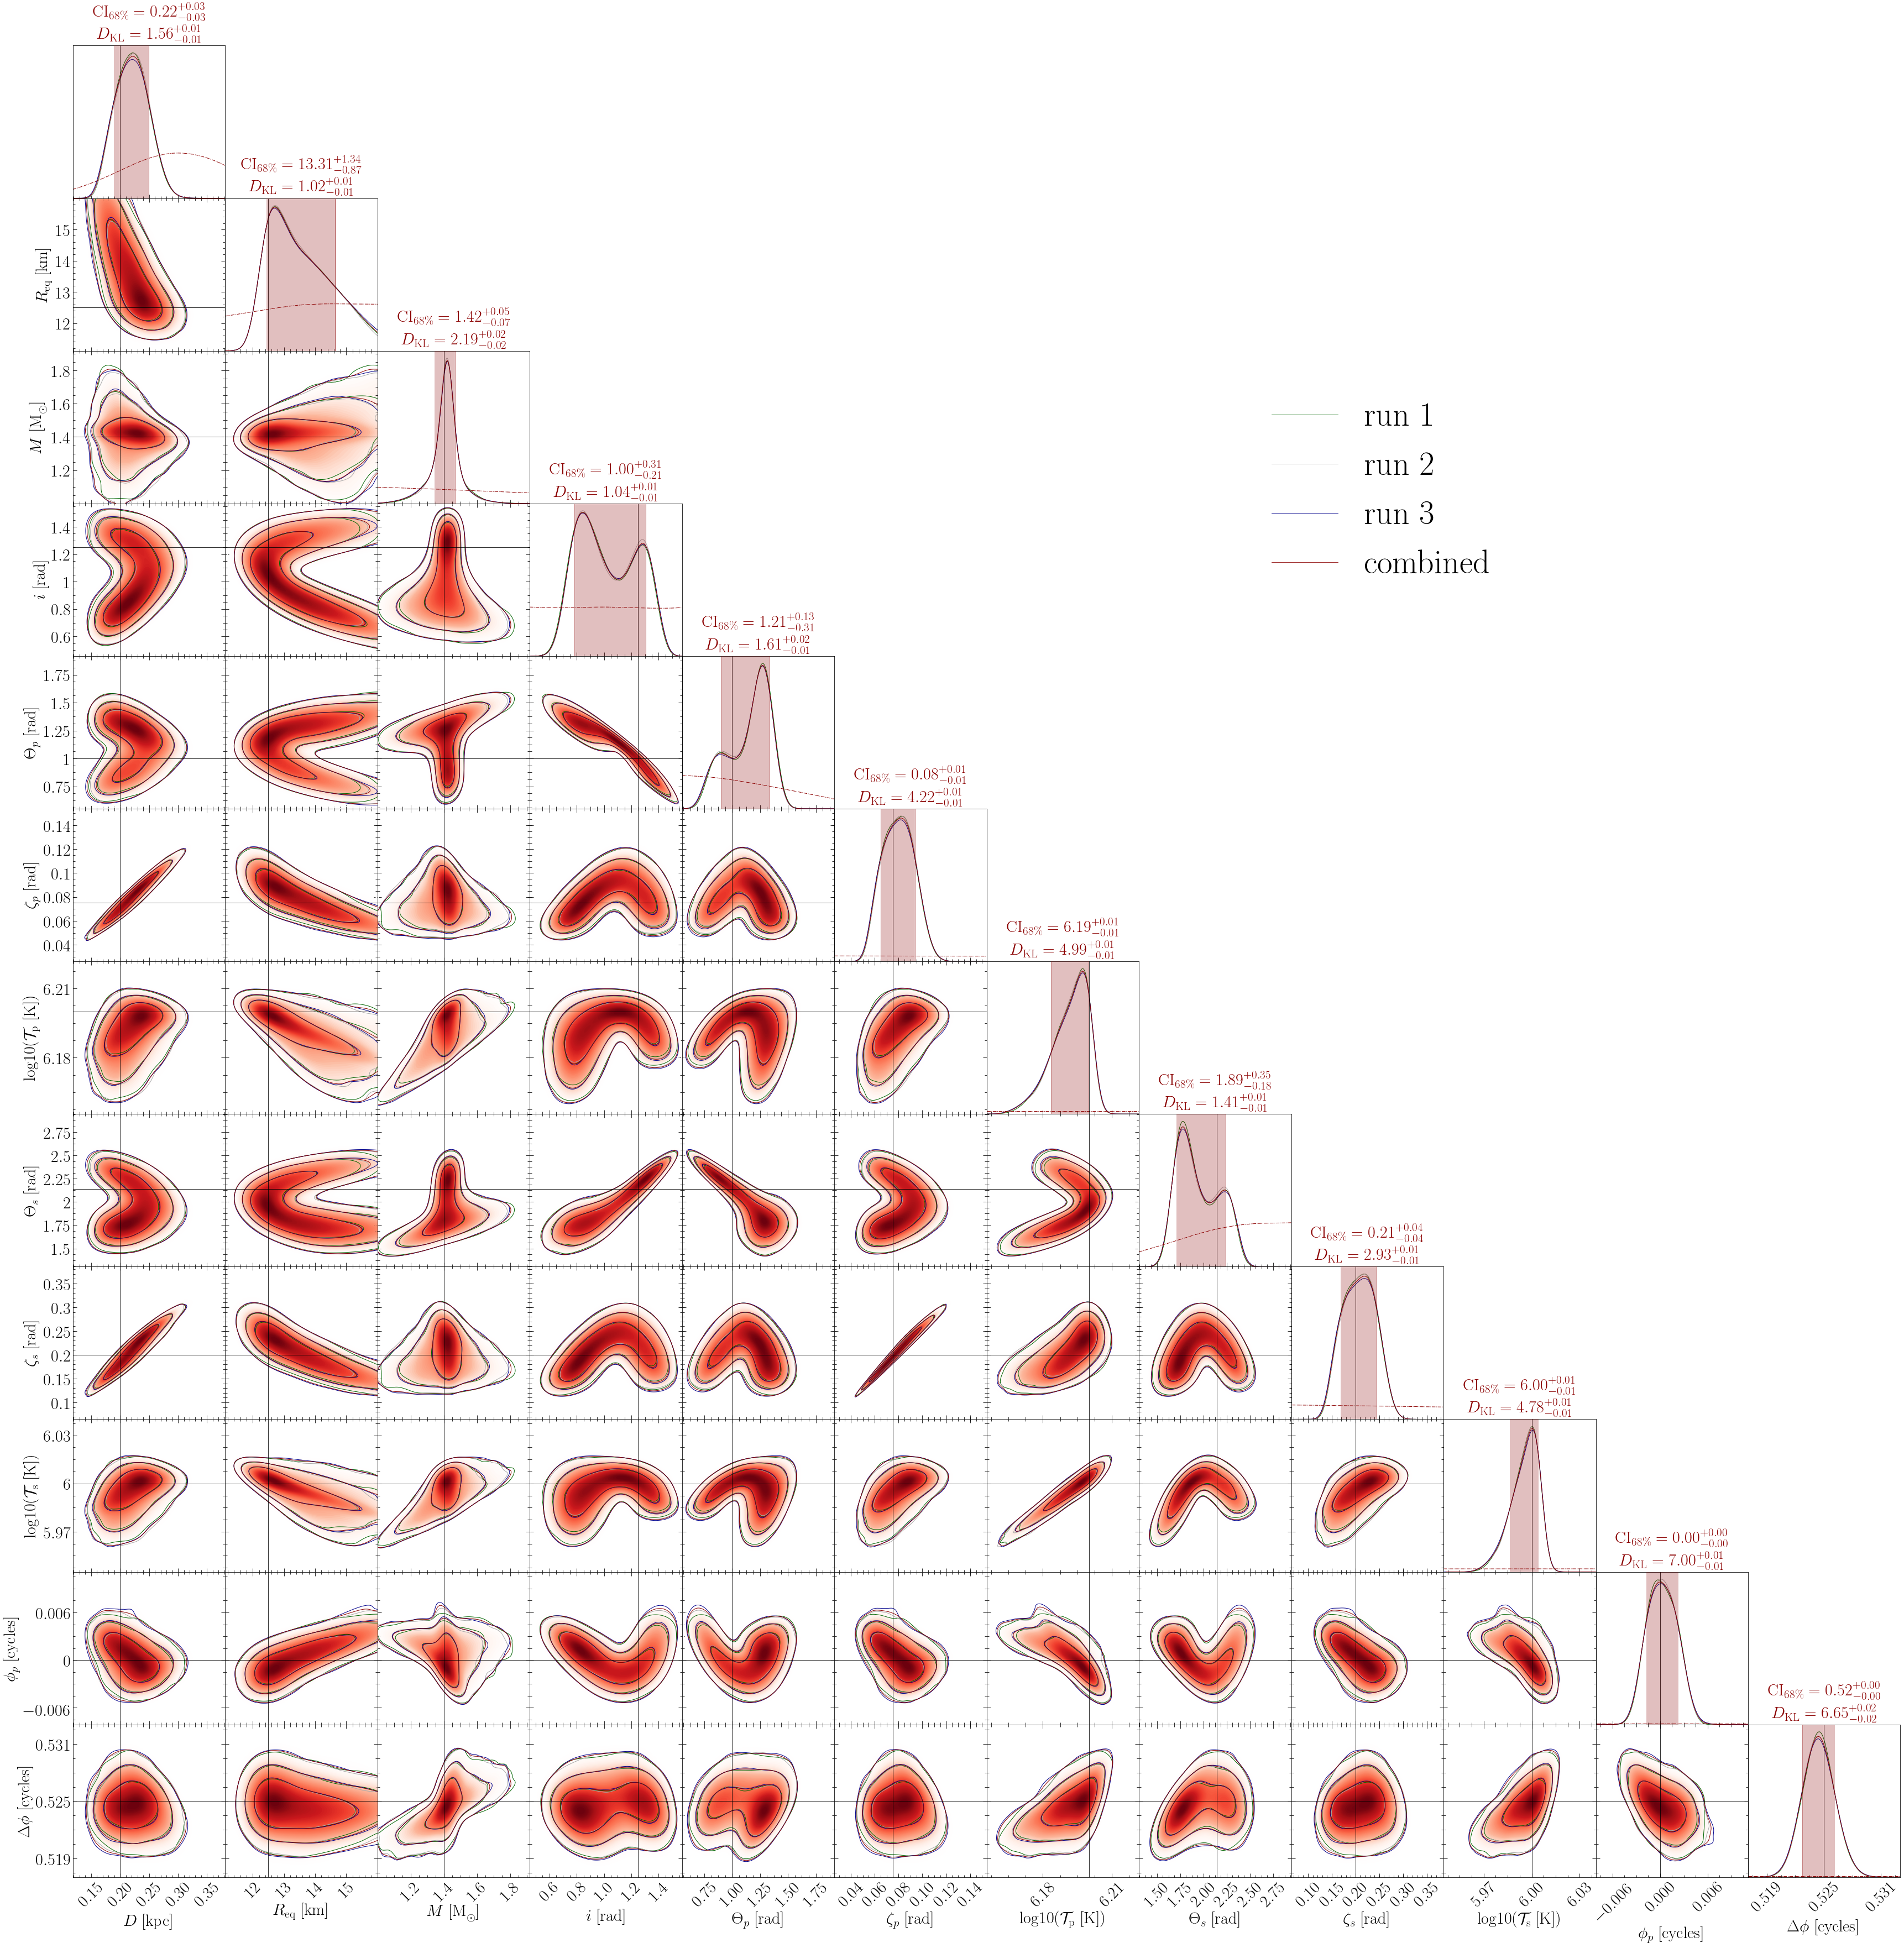

In [14]:
pp.plot_posteriorDensity(params=['distance',
                                 'radius',
                                 'mass',
                                 'inclination',
                                 'colatitude_p',
                                 'radius_p',
                                 'temperature_p',
                                 'colatitude_s',
                                 'radius_s',
                                 'temperature_s',
                                 'phase_shift_p',
                                 'phase_separation'],
                         run_IDs=['run 3','run 2','run 1',],
                         prior_density=True,
                         KL_divergence=True,
                         ndraws=1e5,
                         combine=True, combine_all=True, only_combined=False,
                         param_plot_lims={},
                         bootstrap_estimators=True,
                         bootstrap_density=False,
                         crosshairs=True,
                         write=True,
                         ext='.png',
                         maxdots=4000,
                         root_filename='twospots',
                         credible_interval_1d=True,
                         annotate_credible_interval=True,
                         compute_all_intervals=True,
                         sixtyeight=True,
                         x_label_rotation=45.0,
                         num_plot_contours=3,
                         subplot_size=4.0,
                         tick_prune=None,
                         legend_loc='lower left',
                         legend_corner_coords=(0.65,0.7),
                         legend_frameon=False,
                         scale_attrs={'legend_fontsize': 5.0,
                                      'axes_fontsize': 'lab_fontsize',
                                      'lab_fontsize': 2.0},
                         colormap='Reds',
                         shaded=True,
                         shade_root_index=-1,
                         rasterized_shade=True,
                         no_ylabel=True,
                         no_ytick=True,
                         lw=1.0,
                         lw_1d=1.0,
                         filled=False,
                         normalize=True,
                         veneer=True,
                         tqdm_kwargs={'disable': False},
                         lengthen=2.0,
                         embolden=1.0,
                         nx=500,
                         scale_ymax=1.1,
                         n_simulate=200)

>> Plotting data and model for posterior checking...
>> Curating set of runs for posterior plotting...
>> Run set curated.
>> Instantiating a pulse plotter for posterior checking...
>> Pulse plotter instantiated.
Weights renormalized to sum to unity.
>> Checking whether an existing cache can be read:
>> Cache state determined.
>> Adding credible intervals on source photon flux signal as function of phase...


>> Credible intervals added.
>> Adding credible intervals on source count rate signal as function of phase...


>> Credible intervals added.
>> Adding credible intervals on source photon specific flux spectrum...


>> Credible intervals added.
>> Adding count data to topmost panel split over two phase cycles...
>> Data added.
>> Adding posterior expectation of phase-channel count signalto second panel...
>> Adding residuals between data and posterior expected signal to third panel...
>> Residuals added.
>> Posterior expected signal added.
>> Adding posterior expectation of source 

/home/thomas/anaconda/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


>> Written.
>> Plotted data and model for posterior checking.


/home/thomas/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


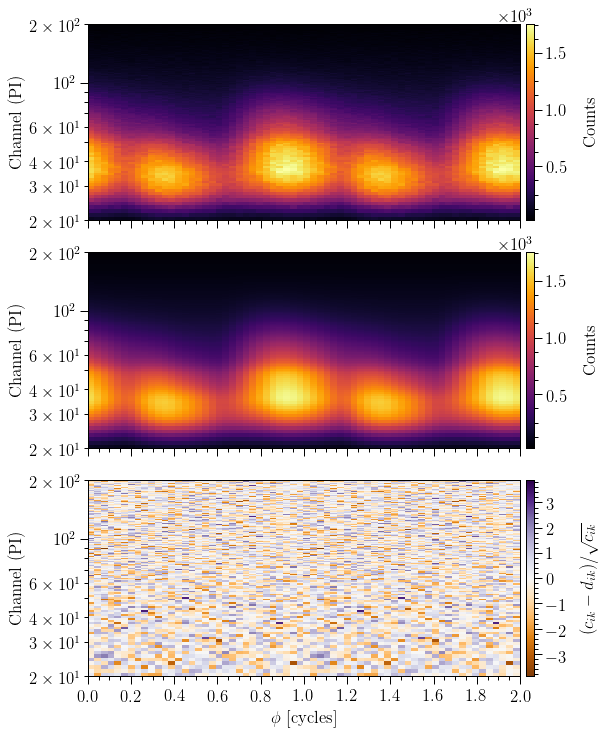

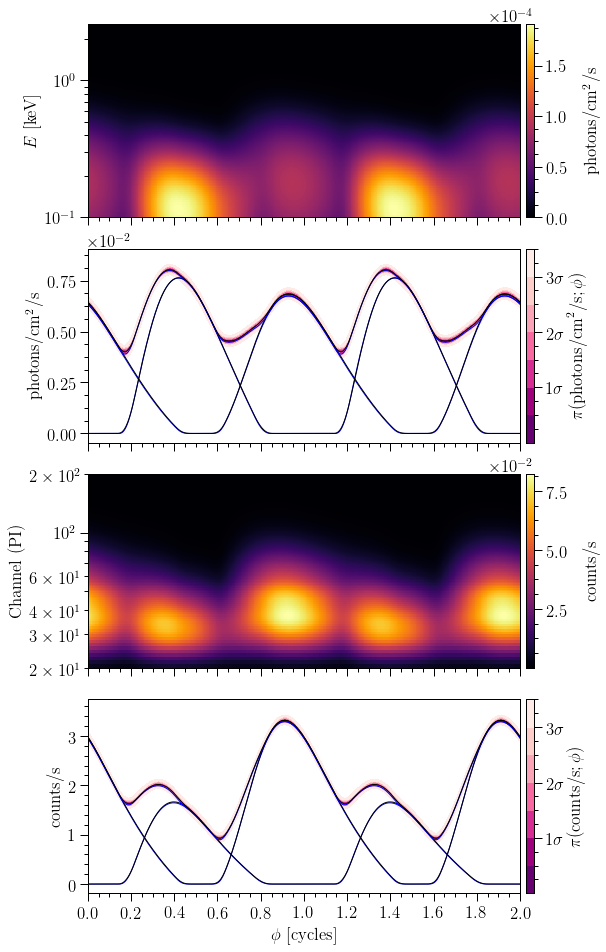

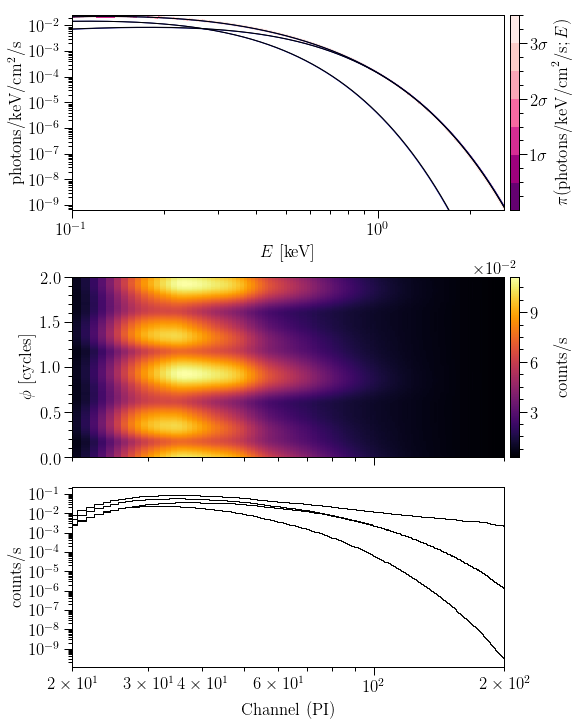

In [10]:
likelihood.threads = 4
pp.plot_pulse_and_spectrum(run_IDs=['run 3', 'run 2', 'run 1',],
                              combine=True,
                              combine_all=True,
                              show_components=True,
                              cache=True,
                              nsamples=500,
                              num_phases=500,
                              absorbed_spectrum=False,
                              archive=True,
                              ny=500,
                              write=True,
                              root_filename='default',
                              plot_truth=True,
                              use_fgivenx=True,
                              fscale=1.3,
                              truth_line_kwargs = dict(color='b',
                                                         ls='-',
                                                         lw=1.0,
                                                         alpha=1.0))

>> Executing posterior density estimation...
>> Curating set of runs for posterior plotting...
>> Run set curated.
>> Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['imp', 'ipp']
plotting:  ['imp', 'ims']
plotting:  ['ipp', 'ims']
>> Adding 1D marginal prior density functions...
>> Estimating 1D marginal KL-divergences in bits...
imp KL-divergence = 0.6340/-0.0076/+0.0094
ipp KL-divergence = 3.3560/-0.0136/+0.0119
ims KL-divergence = 2.9449/-0.0151/+0.0168
>> Estimated 1D marginal KL-divergences.
>> Added 1D marginal prior density functions.
>> Veneering spines and axis ticks...
>> Veneered.
>> Adding parameter truth crosshairs...
>> Added crosshairs.
>> Adding 1D marginal credible intervals...
>> Added 1D marginal credible intervals.
>> Constructed lower-triangle posterior density plot.
>> Simulating nested sampling realisations for posterior density error visualisation...
>> Adding density error information to triangle plot...
nestcheck: Using :class

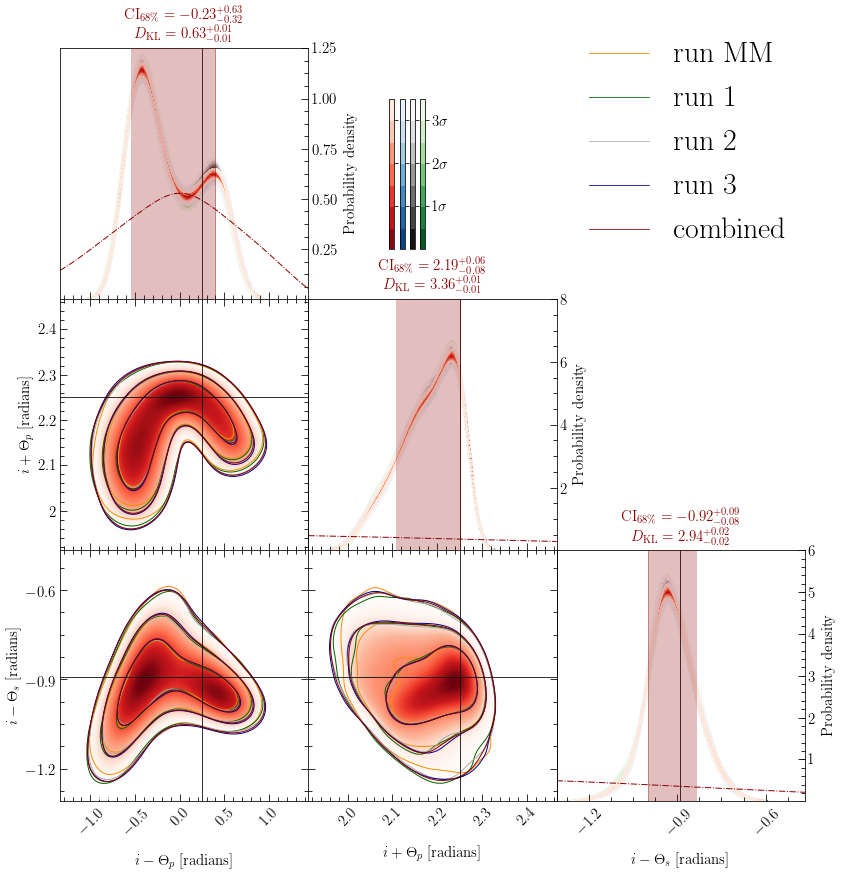

In [27]:
pp.plot_posteriorDensity(params=['imp',
                                 'ipp',
                                 'ims'],
                         run_IDs=['run 3','run 2','run 1', 'run MM'],
                         prior_density=True,
                         KL_divergence=True,
                         ndraws=1e5,
                         combine=True, combine_all=True, only_combined=False,
                         param_plot_lims={},
                         bootstrap_estimators=True,
                         bootstrap_density=True,
                         crosshairs=True,
                         write=True,
                         ext='.png',
                         maxdots=4000,
                         root_filename='default_inset_wMM',
                         credible_interval_1d=True,
                         annotate_credible_interval=True,
                         compute_all_intervals=False,
                         sixtyeight=True,
                         x_label_rotation=45.0,
                         num_plot_contours=3,
                         subplot_size=4.0,
                         tick_prune=None,
                         legend_loc='lower left',
                         legend_corner_coords=(0.65,0.7),
                         legend_frameon=False,
                         scale_attrs={'legend_fontsize': 2.5,
                                      'axes_fontsize': 'lab_fontsize'},
                         colormap='Reds',
                         shaded=True,
                         shade_root_index=-1,
                         rasterized_shade=True,
                         lw=1.0,
                         lw_1d=0.0,
                         filled=False,
                         normalize=True,
                         veneer=True,
                         tqdm_kwargs={'disable': False},
                         lengthen=2.0,
                         embolden=1.0,
                         nx=500,
                         scale_ymax=1.1,
                         n_simulate=200)

In [20]:
wmax = np.max(pp.runs.combined.samples[:,0])

In [21]:
(pp.runs.combined.samples[pp.runs.combined.samples[:,0]>=1.0e-6*wmax,0]).shape # combined number of samples

(64371,)